## **Imports**

In [1]:
pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.6 MB/s eta 0:00:00


In [2]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from rapidfuzz import fuzz, process
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Loading & Exploration**

- In this section, the data was loaded line by line from the csv file and then converted to a pandas dataframe.

- Columns like the customer date of birth, transaction time, transaction amount, and account balance  were adjusted to match the expected type.

- Records with unrealistic date of birth were dropped.

- Data was checked against nulls and duplicates.

- Owned Products were cleaned against encoding issues, and were One Hot Encoded for each record.



In [4]:
csv_data = {'TransactionID': [],
            'CustomerID': [],
            'CustomerDOB': [],
            'CustGender': [],
            'CustLocation': [],
            'CustAccountBalance': [],
            'TransactionDate': [],
            'TransactionTime': [],
            'TransactionAmount (INR)': [],
            'OwnedProducts1': [],
            'OwnedProducts2': [],
            'OwnedProducts3': [],
            'OwnedProducts4': [],
            'OwnedProducts5': [],
            'OwnedProducts6': []
          }



# Get the data from the csv file
with open('/content/drive/MyDrive/bank_customer_transactions.csv') as file:

    line = file.readline()

    while line:

      line = file.readline()
      data = line.split('\n')[0].split(',')
      data_idx = 0

      for key in csv_data.keys():

          if data_idx < len(data):
              csv_data[key].append(data[data_idx])
              data_idx += 1
          else:
            csv_data[key].append(np.nan)

In [5]:
csv_data

{'TransactionID': ['T1',
  'T2',
  'T3',
  'T4',
  'T5',
  'T6',
  'T7',
  'T8',
  'T9',
  'T10',
  'T11',
  'T12',
  'T13',
  'T14',
  'T15',
  'T16',
  'T17',
  'T18',
  'T19',
  'T20',
  'T21',
  'T22',
  'T23',
  'T24',
  'T25',
  'T26',
  'T27',
  'T28',
  'T29',
  'T30',
  'T31',
  'T32',
  'T33',
  'T34',
  'T35',
  'T36',
  'T37',
  'T38',
  'T39',
  'T40',
  'T41',
  'T42',
  'T43',
  'T44',
  'T45',
  'T46',
  'T47',
  'T48',
  'T49',
  'T50',
  'T51',
  'T52',
  'T53',
  'T54',
  'T55',
  'T56',
  'T57',
  'T58',
  'T59',
  'T60',
  'T61',
  'T62',
  'T63',
  'T64',
  'T65',
  'T66',
  'T67',
  'T68',
  'T69',
  'T70',
  'T71',
  'T72',
  'T73',
  'T74',
  'T75',
  'T76',
  'T77',
  'T78',
  'T79',
  'T80',
  'T81',
  'T82',
  'T83',
  'T84',
  'T85',
  'T86',
  'T87',
  'T88',
  'T89',
  'T90',
  'T91',
  'T92',
  'T93',
  'T94',
  'T95',
  'T96',
  'T97',
  'T98',
  'T99',
  'T100',
  'T101',
  'T102',
  'T103',
  'T104',
  'T105',
  'T106',
  'T107',
  'T108',
  'T109',
 

In [6]:
# Read the data without headers
transactions_df = pd.DataFrame(csv_data)

In [7]:
# Investigate the loaded data
transactions_df.head()

TransactionID CustomerID         CustomerDOB CustGender CustLocation  \
0            T1   C5841053  1994+AC0-01+AC0-10          F   JAMSHEDPUR   
1            T2   C2142763  2057+AC0-04+AC0-04          M      JHAJJAR   
2            T3   C4417068  1996+AC0-11+AC0-26          F       MUMBAI   
3            T4   C5342380  2073+AC0-09+AC0-14          F       MUMBAI   
4            T5   C9031234  1988+AC0-03+AC0-24          F  NAVI MUMBAI   

  CustAccountBalance TransactionDate TransactionTime TransactionAmount (INR)  \
0           17819.05          2/8/16          143207                      25   
1            2270.69          2/8/16          141858                   27999   
2           17874.44          2/8/16          142712                     459   
3          866503.21          2/8/16          142714                    2060   
4            6714.43          2/8/16          181156                  1762.5   

              OwnedProducts1 OwnedProducts2 OwnedProducts3 OwnedProducts4  \
0           +ACI-credit card          loans   savings+ACI-            NaN   
1                        tds            NaN            NaN            NaN   
2                 +ACI-loans   savings+ACI-            NaN            NaN   
3  +ACI-long term investment   savings+ACI-            NaN            NaN   
4                 +ACI-loans   savings+ACI-            NaN            NaN   

  OwnedProducts5 OwnedProducts6  
0            NaN            NaN  
1            NaN            NaN  
2            NaN            NaN  
3            NaN            NaN  
4            NaN            NaN

In [8]:
# Investigate the shape of the dataframe
print('Shape of the data:', transactions_df.shape)

Shape of the data: (1048568, 15)


In [9]:
# Modify corrupted dates (make it in the form of yyyy-mm-dd)
transactions_df['CustomerDOB'] = transactions_df['CustomerDOB'].str.replace('+AC0-', '-', regex=False)

In [10]:
# Investigate the modified date column
transactions_df.head()

TransactionID CustomerID CustomerDOB CustGender CustLocation  \
0            T1   C5841053  1994-01-10          F   JAMSHEDPUR   
1            T2   C2142763  2057-04-04          M      JHAJJAR   
2            T3   C4417068  1996-11-26          F       MUMBAI   
3            T4   C5342380  2073-09-14          F       MUMBAI   
4            T5   C9031234  1988-03-24          F  NAVI MUMBAI   

  CustAccountBalance TransactionDate TransactionTime TransactionAmount (INR)  \
0           17819.05          2/8/16          143207                      25   
1            2270.69          2/8/16          141858                   27999   
2           17874.44          2/8/16          142712                     459   
3          866503.21          2/8/16          142714                    2060   
4            6714.43          2/8/16          181156                  1762.5   

              OwnedProducts1 OwnedProducts2 OwnedProducts3 OwnedProducts4  \
0           +ACI-credit card          loans   savings+ACI-            NaN   
1                        tds            NaN            NaN            NaN   
2                 +ACI-loans   savings+ACI-            NaN            NaN   
3  +ACI-long term investment   savings+ACI-            NaN            NaN   
4                 +ACI-loans   savings+ACI-            NaN            NaN   

  OwnedProducts5 OwnedProducts6  
0            NaN            NaN  
1            NaN            NaN  
2            NaN            NaN  
3            NaN            NaN  
4            NaN            NaN

In [11]:
# Modify corrupted dates (convert to datetime format)
transactions_df['CustomerDOB'] =  pd.to_datetime(transactions_df['CustomerDOB'], errors='coerce')

In [12]:
# Show maximum Customer Date of Birth
transactions_df['CustomerDOB'].max()

Timestamp('2074-12-31 00:00:00')

In [13]:
# Show minimum Customer Date of Birth
transactions_df['CustomerDOB'].min()

Timestamp('1800-01-01 00:00:00')

In [14]:
# Only keep customers of valid date of birth
transactions_df = transactions_df[transactions_df['CustomerDOB'] <= ('2025-01-01 00:00:00')]

In [15]:
# Investigate the modified date column
transactions_df.head()

TransactionID CustomerID CustomerDOB CustGender CustLocation  \
0            T1   C5841053  1994-01-10          F   JAMSHEDPUR   
2            T3   C4417068  1996-11-26          F       MUMBAI   
4            T5   C9031234  1988-03-24          F  NAVI MUMBAI   
6            T7   C7126560  1992-01-26          F       MUMBAI   
7            T8   C1220223  1982-01-27          M       MUMBAI   

  CustAccountBalance TransactionDate TransactionTime TransactionAmount (INR)  \
0           17819.05          2/8/16          143207                      25   
2           17874.44          2/8/16          142712                     459   
4            6714.43          2/8/16          181156                  1762.5   
6             973.46          2/8/16          173806                     566   
7           95075.54          2/8/16          170537                     148   

     OwnedProducts1         OwnedProducts2    OwnedProducts3 OwnedProducts4  \
0  +ACI-credit card                  loans      savings+ACI-            NaN   
2        +ACI-loans           savings+ACI-               NaN            NaN   
4        +ACI-loans           savings+ACI-               NaN            NaN   
6        +ACI-loans   retirement plan+ACI-               NaN            NaN   
7          +ACI-cds            credit card   retirement plan   savings+ACI-   

  OwnedProducts5 OwnedProducts6  
0            NaN            NaN  
2            NaN            NaN  
4            NaN            NaN  
6            NaN            NaN  
7            NaN            NaN

In [16]:
# Observe the shape of the dataframe
transactions_df.shape

(939968, 15)

In [17]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 939968 entries, 0 to 1048566
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            939968 non-null  object        
 1   CustomerID               939968 non-null  object        
 2   CustomerDOB              939968 non-null  datetime64[ns]
 3   CustGender               939968 non-null  object        
 4   CustLocation             939968 non-null  object        
 5   CustAccountBalance       939968 non-null  object        
 6   TransactionDate          939968 non-null  object        
 7   TransactionTime          939968 non-null  object        
 8   TransactionAmount (INR)  939968 non-null  object        
 9   OwnedProducts1           939968 non-null  object        
 10  OwnedProducts2           688151 non-null  object        
 11  OwnedProducts3           466989 non-null  object        
 12  OwnedProducts4      

In [18]:
def convert_to_float(string_value):

    '''
    Converts a string value to a float. If the conversion fails, it returns NaN.

    Args:
        string_value (str): The string value to be converted to float.

    Returns:
        float: The converted float value, or NaN if conversion fails.
    '''

    try:
      return float(string_value)
    except:
      return np.nan

# Convert string values to float
transactions_df['CustAccountBalance'] = transactions_df['CustAccountBalance'].apply(convert_to_float)
transactions_df['TransactionAmount (INR)'] = transactions_df['TransactionAmount (INR)'].apply(convert_to_float)

In [19]:
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'], errors='coerce')

<ipython-input-19-0e7cd9e15534>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'], errors='coerce')


In [20]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 939968 entries, 0 to 1048566
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            939968 non-null  object        
 1   CustomerID               939968 non-null  object        
 2   CustomerDOB              939968 non-null  datetime64[ns]
 3   CustGender               939968 non-null  object        
 4   CustLocation             939968 non-null  object        
 5   CustAccountBalance       937404 non-null  float64       
 6   TransactionDate          939561 non-null  datetime64[ns]
 7   TransactionTime          939968 non-null  object        
 8   TransactionAmount (INR)  939968 non-null  float64       
 9   OwnedProducts1           939968 non-null  object        
 10  OwnedProducts2           688151 non-null  object        
 11  OwnedProducts3           466989 non-null  object        
 12  OwnedProducts4      

In [21]:
def convert_to_int(string_value):

    '''
    Converts a string value to an integer. If conversion fails, returns NaN.

    Args:
        string_value (str): The string to be converted to an integer.

    Returns:
        int or np.nan: The converted integer value if successful, else np.nan.
    '''

    try:
      return int(string_value)
    except:
      return np.nan


def convert_to_timestamp(string_value):

    '''
    Converts a timestamp (in Unix format) to a human-readable time string (HH:MM:SS).
    If conversion fails, returns NaN.

    Args:
        string_value (str): The timestamp value to be converted to a time string.

    Returns:
        str or np.nan: The time in HH:MM:SS format if conversion is successful, else np.nan.
    '''

    try:
      return datetime.utcfromtimestamp(string_value).strftime('%H:%M:%S')
    except:
      return np.nan


transactions_df['TransactionTime'] = transactions_df['TransactionTime'].apply(convert_to_int)
transactions_df['TransactionTime'] = transactions_df['TransactionTime'].apply(convert_to_timestamp)
transactions_df['TransactionTime'] = pd.to_datetime(transactions_df['TransactionTime'], format='%H:%M:%S', errors='coerce')         # Convert transaction time to datetime format

In [22]:
transactions_df['TransactionTime']

0         1900-01-01 15:46:47
2         1900-01-01 15:38:32
4         1900-01-01 02:19:16
6         1900-01-01 00:16:46
7         1900-01-01 23:22:17
                  ...        
1048562   1900-01-01 03:20:24
1048563   1900-01-01 03:02:14
1048564   1900-01-01 02:55:13
1048565   1900-01-01 03:18:26
1048566   1900-01-01 02:20:22
Name: TransactionTime, Length: 939968, dtype: datetime64[ns]

In [23]:
# Clean the owned products columns
for col in ['OwnedProducts1', 'OwnedProducts2', 'OwnedProducts3', 'OwnedProducts4', 'OwnedProducts5', 'OwnedProducts6']:
    transactions_df[col] = transactions_df[col].astype(str).str.replace(r'\+ACI-|\+AC0-|\+ACI|=|\+', '', regex=True)

In [24]:
transactions_df.head()

TransactionID CustomerID CustomerDOB CustGender CustLocation  \
0            T1   C5841053  1994-01-10          F   JAMSHEDPUR   
2            T3   C4417068  1996-11-26          F       MUMBAI   
4            T5   C9031234  1988-03-24          F  NAVI MUMBAI   
6            T7   C7126560  1992-01-26          F       MUMBAI   
7            T8   C1220223  1982-01-27          M       MUMBAI   

   CustAccountBalance TransactionDate     TransactionTime  \
0            17819.05      2016-02-08 1900-01-01 15:46:47   
2            17874.44      2016-02-08 1900-01-01 15:38:32   
4             6714.43      2016-02-08 1900-01-01 02:19:16   
6              973.46      2016-02-08 1900-01-01 00:16:46   
7            95075.54      2016-02-08 1900-01-01 23:22:17   

   TransactionAmount (INR) OwnedProducts1    OwnedProducts2    OwnedProducts3  \
0                     25.0    credit card             loans           savings   
2                    459.0          loans           savings               nan   
4                   1762.5          loans           savings               nan   
6                    566.0          loans   retirement plan               nan   
7                    148.0            cds       credit card   retirement plan   

  OwnedProducts4 OwnedProducts5 OwnedProducts6  
0            nan            nan            nan  
2            nan            nan            nan  
4            nan            nan            nan  
6            nan            nan            nan  
7        savings            nan            nan

In [25]:
# Get Combined Products for each customer
transactions_df['OwnedProducts_combined'] = transactions_df[['OwnedProducts1', 'OwnedProducts2', 'OwnedProducts3', 'OwnedProducts4', 'OwnedProducts5', 'OwnedProducts6']].apply(lambda row: '/'.join(str(val).strip() for val in row.dropna() if not str(val).replace('.', '', 1).isdigit()), axis=1)

# One-hot encode the combined column
ohe_df = transactions_df['OwnedProducts_combined'].str.get_dummies('/')

# Merge the one-hot encoded columns back into the original DataFrame
transactions_df = pd.concat([transactions_df, ohe_df], axis=1)

In [26]:
transactions_df.head()

TransactionID CustomerID CustomerDOB CustGender CustLocation  \
0            T1   C5841053  1994-01-10          F   JAMSHEDPUR   
2            T3   C4417068  1996-11-26          F       MUMBAI   
4            T5   C9031234  1988-03-24          F  NAVI MUMBAI   
6            T7   C7126560  1992-01-26          F       MUMBAI   
7            T8   C1220223  1982-01-27          M       MUMBAI   

   CustAccountBalance TransactionDate     TransactionTime  \
0            17819.05      2016-02-08 1900-01-01 15:46:47   
2            17874.44      2016-02-08 1900-01-01 15:38:32   
4             6714.43      2016-02-08 1900-01-01 02:19:16   
6              973.46      2016-02-08 1900-01-01 00:16:46   
7            95075.54      2016-02-08 1900-01-01 23:22:17   

   TransactionAmount (INR) OwnedProducts1  ... OwnedProducts6  \
0                     25.0    credit card  ...            nan   
2                    459.0          loans  ...            nan   
4                   1762.5          loans  ...            nan   
6                    566.0          loans  ...            nan   
7                    148.0            cds  ...            nan   

                            OwnedProducts_combined cds credit card loans  \
0            credit card/loans/savings/nan/nan/nan   0           1     1   
2                    loans/savings/nan/nan/nan/nan   0           0     1   
4                    loans/savings/nan/nan/nan/nan   0           0     1   
6            loans/retirement plan/nan/nan/nan/nan   0           0     1   
7  cds/credit card/retirement plan/savings/nan/nan   1           1     0   

  long term investment  nan  retirement plan  savings  tds  
0                    0    1                0        1    0  
2                    0    1                0        1    0  
4                    0    1                0        1    0  
6                    0    1                1        0    0  
7                    0    1                1        1    0  

[5 rows x 24 columns]

In [27]:
# Drop the original 'OwnedProducts' columns and the combined column
transactions_df.drop(['OwnedProducts1', 'OwnedProducts2', 'OwnedProducts3', 'OwnedProducts4', 'OwnedProducts5', 'OwnedProducts6', 'OwnedProducts_combined', 'nan'], axis=1, inplace=True)

In [28]:
# Observe the columns that were added to our dataframe
transactions_df.columns.tolist()

['TransactionID',
 'CustomerID',
 'CustomerDOB',
 'CustGender',
 'CustLocation',
 'CustAccountBalance',
 'TransactionDate',
 'TransactionTime',
 'TransactionAmount (INR)',
 'cds',
 'credit card',
 'loans',
 'long term investment',
 'retirement plan',
 'savings',
 'tds']

In [29]:
# Check for duplicates
transactions_df.duplicated().sum()

np.int64(0)

In [30]:
# Observe the count of nulls in the dataframe
transactions_df.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                   0
CustGender                    0
CustLocation                  0
CustAccountBalance         2564
TransactionDate             407
TransactionTime             417
TransactionAmount (INR)       0
cds                           0
credit card                   0
loans                         0
long term investment          0
retirement plan               0
savings                       0
tds                           0
dtype: int64

In [31]:
# Drop customers with nan values (to avoid the errors from trying to impute the data, dropping would be safer as we already have enough data)
transactions_df.dropna(inplace=True)

In [32]:
# Observe the count of nulls in the dataframe
transactions_df.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
cds                        0
credit card                0
loans                      0
long term investment       0
retirement plan            0
savings                    0
tds                        0
dtype: int64

In [33]:
# Observe the shape of the new dataframe
transactions_df.shape

(937404, 16)

## **Feature Engineering**

- In this section, various features were extracted for each customer like the min, max and average transactions.

- Features like the customer age, total number of transactions, first, and last transaction dates (parsed their parts) were also extracted.

- Moreover, the frequency of transactions for each customer as well as the average hour of the transaction were extracted.

In [34]:
# Get the customer age
transactions_df['CustomerAge'] = (transactions_df['TransactionDate'] -  transactions_df['CustomerDOB']).dt.days // 365

In [35]:
transactions_df['CustomerAge']

0          22
2          19
4          27
6          24
7          34
           ..
1048562    26
1048563    24
1048564    27
1048565    38
1048566    32
Name: CustomerAge, Length: 937404, dtype: int64

In [36]:
# Show the maximum age
transactions_df['CustomerAge'].max()

217

In [37]:
# Show the minimum age
transactions_df['CustomerAge'].min()

-8

In [38]:
# Remove customers with unreal age
transactions_df = transactions_df[(0 < transactions_df['CustomerAge']) & (transactions_df['CustomerAge'] <= 100)]

In [39]:
# Observe maximum and minimum ages after cleaning
print('Minimum Customer Age:', transactions_df['CustomerAge'].min())
print('Maximum Customer Age:', transactions_df['CustomerAge'].max())

Minimum Customer Age: 1
Maximum Customer Age: 41


In [40]:
# Get total number of transactions
transactions_df['CustomerNumTransactions'] = transactions_df.groupby('CustomerID')['TransactionID'].transform('count')

In [41]:
# Observe the dataframe
transactions_df

TransactionID CustomerID CustomerDOB CustGender   CustLocation  \
0                  T1   C5841053  1994-01-10          F     JAMSHEDPUR   
2                  T3   C4417068  1996-11-26          F         MUMBAI   
4                  T5   C9031234  1988-03-24          F    NAVI MUMBAI   
6                  T7   C7126560  1992-01-26          F         MUMBAI   
7                  T8   C1220223  1982-01-27          M         MUMBAI   
...               ...        ...         ...        ...            ...   
1048562      T1048563   C8020229  1990-04-08          M      NEW DELHI   
1048563      T1048564   C6459278  1992-02-20          M         NASHIK   
1048564      T1048565   C6412354  1989-05-18          M      HYDERABAD   
1048565      T1048566   C6420483  1978-08-30          M  VISAKHAPATNAM   
1048566      T1048567   C8337524  1984-03-05          M           PUNE   

         CustAccountBalance TransactionDate     TransactionTime  \
0                  17819.05      2016-02-08 1900-01-01 15:46:47   
2                  17874.44      2016-02-08 1900-01-01 15:38:32   
4                   6714.43      2016-02-08 1900-01-01 02:19:16   
6                    973.46      2016-02-08 1900-01-01 00:16:46   
7                  95075.54      2016-02-08 1900-01-01 23:22:17   
...                     ...             ...                 ...   
1048562             7635.19      2016-09-18 1900-01-01 03:20:24   
1048563            27311.42      2016-09-18 1900-01-01 03:02:14   
1048564           221757.06      2016-09-18 1900-01-01 02:55:13   
1048565            10117.87      2016-09-18 1900-01-01 03:18:26   
1048566            75734.42      2016-09-18 1900-01-01 02:20:22   

         TransactionAmount (INR)  cds  credit card  loans  \
0                           25.0    0            1      1   
2                          459.0    0            0      1   
4                         1762.5    0            0      1   
6                          566.0    0            0      1   
7                          148.0    1            1      0   
...                          ...  ...          ...    ...   
1048562                    799.0    0            0      1   
1048563                    460.0    0            1      1   
1048564                    770.0    1            1      0   
1048565                   1000.0    0            1      1   
1048566                   1166.0    1            1      0   

         long term investment  retirement plan  savings  tds  CustomerAge  \
0                           0                0        1    0           22   
2                           0                0        1    0           19   
4                           0                0        1    0           27   
6                           0                1        0    0           24   
7                           0                1        1    0           34   
...                       ...              ...      ...  ...          ...   
1048562                     0                0        1    0           26   
1048563                     0                0        1    0           24   
1048564                     0                1        1    1           27   
1048565                     0                0        1    0           38   
1048566                     0                1        1    0           32   

         CustomerNumTransactions  
0                              1  
2                              1  
4                              1  
6                              4  
7                              1  
...                          ...  
1048562                        1  
1048563                        1  
1048564                        1  
1048565                        1  
1048566                        2  

[880194 rows x 18 columns]

In [42]:
# Get maximum Transaction amount
transactions_df['CustomerMaxTransaction'] = transactions_df.groupby('CustomerID')['TransactionAmount (INR)'].transform('max')

In [43]:
# Get minimum Transaction amount
transactions_df['CustomerMinTransaction'] = transactions_df.groupby('CustomerID')['TransactionAmount (INR)'].transform('min')

In [44]:
# Get average Transaction amount
transactions_df['CustomerAvgTransaction'] = transactions_df.groupby('CustomerID')['TransactionAmount (INR)'].transform('mean')

In [45]:
# Observe the dataframe
transactions_df

TransactionID CustomerID CustomerDOB CustGender   CustLocation  \
0                  T1   C5841053  1994-01-10          F     JAMSHEDPUR   
2                  T3   C4417068  1996-11-26          F         MUMBAI   
4                  T5   C9031234  1988-03-24          F    NAVI MUMBAI   
6                  T7   C7126560  1992-01-26          F         MUMBAI   
7                  T8   C1220223  1982-01-27          M         MUMBAI   
...               ...        ...         ...        ...            ...   
1048562      T1048563   C8020229  1990-04-08          M      NEW DELHI   
1048563      T1048564   C6459278  1992-02-20          M         NASHIK   
1048564      T1048565   C6412354  1989-05-18          M      HYDERABAD   
1048565      T1048566   C6420483  1978-08-30          M  VISAKHAPATNAM   
1048566      T1048567   C8337524  1984-03-05          M           PUNE   

         CustAccountBalance TransactionDate     TransactionTime  \
0                  17819.05      2016-02-08 1900-01-01 15:46:47   
2                  17874.44      2016-02-08 1900-01-01 15:38:32   
4                   6714.43      2016-02-08 1900-01-01 02:19:16   
6                    973.46      2016-02-08 1900-01-01 00:16:46   
7                  95075.54      2016-02-08 1900-01-01 23:22:17   
...                     ...             ...                 ...   
1048562             7635.19      2016-09-18 1900-01-01 03:20:24   
1048563            27311.42      2016-09-18 1900-01-01 03:02:14   
1048564           221757.06      2016-09-18 1900-01-01 02:55:13   
1048565            10117.87      2016-09-18 1900-01-01 03:18:26   
1048566            75734.42      2016-09-18 1900-01-01 02:20:22   

         TransactionAmount (INR)  cds  ...  loans  long term investment  \
0                           25.0    0  ...      1                     0   
2                          459.0    0  ...      1                     0   
4                         1762.5    0  ...      1                     0   
6                          566.0    0  ...      1                     0   
7                          148.0    1  ...      0                     0   
...                          ...  ...  ...    ...                   ...   
1048562                    799.0    0  ...      1                     0   
1048563                    460.0    0  ...      1                     0   
1048564                    770.0    1  ...      0                     0   
1048565                   1000.0    0  ...      1                     0   
1048566                   1166.0    1  ...      0                     0   

         retirement plan  savings  tds  CustomerAge  CustomerNumTransactions  \
0                      0        1    0           22                        1   
2                      0        1    0           19                        1   
4                      0        1    0           27                        1   
6                      1        0    0           24                        4   
7                      1        1    0           34                        1   
...                  ...      ...  ...          ...                      ...   
1048562                0        1    0           26                        1   
1048563                0        1    0           24                        1   
1048564                1        1    1           27                        1   
1048565                0        1    0           38                        1   
1048566                1        1    0           32                        2   

         CustomerMaxTransaction  CustomerMinTransaction  \
0                          25.0                    25.0   
2                         459.0                   459.0   
4                        1762.5                  1762.5   
6                         566.0                    19.0   
7                         148.0                   148.0   
...                         ...                     ...   
1048562                   799.0        

In [46]:
# Get the first transaction date
transactions_df['CustomerFirstTransaction'] = transactions_df.groupby('CustomerID')['TransactionDate'].transform('min')

In [47]:
# Get the latest transaction date
transactions_df['CustomerLastTransaction'] = transactions_df.groupby('CustomerID')['TransactionDate'].transform('max')

In [48]:
# Get the number of days between first & last transaction
transactions_df['TransactionPeriodDays'] = (transactions_df['CustomerLastTransaction'] - transactions_df['CustomerFirstTransaction']).dt.days
transactions_df['TransactionPeriodDays'] = transactions_df['TransactionPeriodDays'].replace(0, 1)                                             # Replace 0 with 1 to avoid zero division

In [49]:
# Get the frequency of the transactions: transactions per day
transactions_df['TransactionFrequencyPerDay'] = transactions_df['CustomerNumTransactions'] / transactions_df['TransactionPeriodDays']

In [50]:
# Observe the dataframe
transactions_df

TransactionID CustomerID CustomerDOB CustGender   CustLocation  \
0                  T1   C5841053  1994-01-10          F     JAMSHEDPUR   
2                  T3   C4417068  1996-11-26          F         MUMBAI   
4                  T5   C9031234  1988-03-24          F    NAVI MUMBAI   
6                  T7   C7126560  1992-01-26          F         MUMBAI   
7                  T8   C1220223  1982-01-27          M         MUMBAI   
...               ...        ...         ...        ...            ...   
1048562      T1048563   C8020229  1990-04-08          M      NEW DELHI   
1048563      T1048564   C6459278  1992-02-20          M         NASHIK   
1048564      T1048565   C6412354  1989-05-18          M      HYDERABAD   
1048565      T1048566   C6420483  1978-08-30          M  VISAKHAPATNAM   
1048566      T1048567   C8337524  1984-03-05          M           PUNE   

         CustAccountBalance TransactionDate     TransactionTime  \
0                  17819.05      2016-02-08 1900-01-01 15:46:47   
2                  17874.44      2016-02-08 1900-01-01 15:38:32   
4                   6714.43      2016-02-08 1900-01-01 02:19:16   
6                    973.46      2016-02-08 1900-01-01 00:16:46   
7                  95075.54      2016-02-08 1900-01-01 23:22:17   
...                     ...             ...                 ...   
1048562             7635.19      2016-09-18 1900-01-01 03:20:24   
1048563            27311.42      2016-09-18 1900-01-01 03:02:14   
1048564           221757.06      2016-09-18 1900-01-01 02:55:13   
1048565            10117.87      2016-09-18 1900-01-01 03:18:26   
1048566            75734.42      2016-09-18 1900-01-01 02:20:22   

         TransactionAmount (INR)  cds  ...  tds  CustomerAge  \
0                           25.0    0  ...    0           22   
2                          459.0    0  ...    0           19   
4                         1762.5    0  ...    0           27   
6                          566.0    0  ...    0           24   
7                          148.0    1  ...    0           34   
...                          ...  ...  ...  ...          ...   
1048562                    799.0    0  ...    0           26   
1048563                    460.0    0  ...    0           24   
1048564                    770.0    1  ...    1           27   
1048565                   1000.0    0  ...    0           38   
1048566                   1166.0    1  ...    0           32   

         CustomerNumTransactions  CustomerMaxTransaction  \
0                              1                    25.0   
2                              1                   459.0   
4                              1                  1762.5   
6                              4                   566.0   
7                              1                   148.0   
...                          ...                     ...   
1048562                        1                   799.0   
1048563                        1                   460.0   
1048564                        1                   770.0   
1048565                        1                  1000.0   
1048566                        2                  1166.0   

         CustomerMinTransaction  CustomerAvgTransaction  \
0                          25.0                   25.00   
2                         459.0                  459.00   
4                        1762.5                 1762.50   
6                          19.0                  205.25   
7                         148.0                  148.00   
...                         ...                     ...   
1048562                   799.0                  799.00   
1048563                   460.0                  460.00   
1048564                   770.0                  770.00   
1048565                  1000.0                 1000.00   
1048566                   310.0                  738.00   

         CustomerFirstTransaction  CustomerLastTransaction  \
0                      2016-02-08               2016-

In [51]:
# Get the aveage hour of transactions for each customer
transactions_df['TransactionHour'] = transactions_df['TransactionTime'].dt.hour
transactions_df['AvgTransactionHour'] = transactions_df.groupby('CustomerID')['TransactionHour'].transform('mean')

In [52]:
# Drop the unwanted column of transaction hour
transactions_df.drop(columns=['TransactionHour'], inplace=True)

In [53]:
# Observe the dataframe
transactions_df

TransactionID CustomerID CustomerDOB CustGender   CustLocation  \
0                  T1   C5841053  1994-01-10          F     JAMSHEDPUR   
2                  T3   C4417068  1996-11-26          F         MUMBAI   
4                  T5   C9031234  1988-03-24          F    NAVI MUMBAI   
6                  T7   C7126560  1992-01-26          F         MUMBAI   
7                  T8   C1220223  1982-01-27          M         MUMBAI   
...               ...        ...         ...        ...            ...   
1048562      T1048563   C8020229  1990-04-08          M      NEW DELHI   
1048563      T1048564   C6459278  1992-02-20          M         NASHIK   
1048564      T1048565   C6412354  1989-05-18          M      HYDERABAD   
1048565      T1048566   C6420483  1978-08-30          M  VISAKHAPATNAM   
1048566      T1048567   C8337524  1984-03-05          M           PUNE   

         CustAccountBalance TransactionDate     TransactionTime  \
0                  17819.05      2016-02-08 1900-01-01 15:46:47   
2                  17874.44      2016-02-08 1900-01-01 15:38:32   
4                   6714.43      2016-02-08 1900-01-01 02:19:16   
6                    973.46      2016-02-08 1900-01-01 00:16:46   
7                  95075.54      2016-02-08 1900-01-01 23:22:17   
...                     ...             ...                 ...   
1048562             7635.19      2016-09-18 1900-01-01 03:20:24   
1048563            27311.42      2016-09-18 1900-01-01 03:02:14   
1048564           221757.06      2016-09-18 1900-01-01 02:55:13   
1048565            10117.87      2016-09-18 1900-01-01 03:18:26   
1048566            75734.42      2016-09-18 1900-01-01 02:20:22   

         TransactionAmount (INR)  cds  ...  CustomerAge  \
0                           25.0    0  ...           22   
2                          459.0    0  ...           19   
4                         1762.5    0  ...           27   
6                          566.0    0  ...           24   
7                          148.0    1  ...           34   
...                          ...  ...  ...          ...   
1048562                    799.0    0  ...           26   
1048563                    460.0    0  ...           24   
1048564                    770.0    1  ...           27   
1048565                   1000.0    0  ...           38   
1048566                   1166.0    1  ...           32   

         CustomerNumTransactions  CustomerMaxTransaction  \
0                              1                    25.0   
2                              1                   459.0   
4                              1                  1762.5   
6                              4                   566.0   
7                              1                   148.0   
...                          ...                     ...   
1048562                        1                   799.0   
1048563                        1                   460.0   
1048564                        1                   770.0   
1048565                        1                  1000.0   
1048566                        2                  1166.0   

         CustomerMinTransaction  CustomerAvgTransaction  \
0                          25.0                   25.00   
2                         459.0                  459.00   
4                        1762.5                 1762.50   
6                          19.0                  205.25   
7                         148.0                  148.00   
...                         ...                     ...   
1048562                   799.0                  799.00   
1048563                   460.0                  460.00   
1048564                   770.0                  770.00   
1048565                  1000.0                 1000.00   
1048566                   310.0                  738.00   

         CustomerFirstTransaction  CustomerLastTransaction  \
0                      2016-02-08               2016-02-08   
2                      2016-02-08               201

In [54]:
# Get the updated customer account balance
transactions_df['CustomerBalance'] = transactions_df['CustAccountBalance'] - transactions_df['TransactionAmount (INR)']

# Get final balance for each customer
final_balance = (
                  transactions_df.sort_values(by=['CustomerID', 'TransactionDate', 'TransactionTime'])
                  .groupby('CustomerID')
                  .tail(1)
                  .loc[:, ['CustomerID', 'CustomerBalance']]
                  .rename(columns={'CustomerBalance': 'FinalCustomerBalance'})
                )


# Merge final balance to original dataframe
transactions_df = transactions_df.merge(final_balance, on='CustomerID', how='left')

In [55]:
# Observe the dataframe
transactions_df

TransactionID CustomerID CustomerDOB CustGender   CustLocation  \
0                 T1   C5841053  1994-01-10          F     JAMSHEDPUR   
1                 T3   C4417068  1996-11-26          F         MUMBAI   
2                 T5   C9031234  1988-03-24          F    NAVI MUMBAI   
3                 T7   C7126560  1992-01-26          F         MUMBAI   
4                 T8   C1220223  1982-01-27          M         MUMBAI   
...              ...        ...         ...        ...            ...   
880189      T1048563   C8020229  1990-04-08          M      NEW DELHI   
880190      T1048564   C6459278  1992-02-20          M         NASHIK   
880191      T1048565   C6412354  1989-05-18          M      HYDERABAD   
880192      T1048566   C6420483  1978-08-30          M  VISAKHAPATNAM   
880193      T1048567   C8337524  1984-03-05          M           PUNE   

        CustAccountBalance TransactionDate     TransactionTime  \
0                 17819.05      2016-02-08 1900-01-01 15:46:47   
1                 17874.44      2016-02-08 1900-01-01 15:38:32   
2                  6714.43      2016-02-08 1900-01-01 02:19:16   
3                   973.46      2016-02-08 1900-01-01 00:16:46   
4                 95075.54      2016-02-08 1900-01-01 23:22:17   
...                    ...             ...                 ...   
880189             7635.19      2016-09-18 1900-01-01 03:20:24   
880190            27311.42      2016-09-18 1900-01-01 03:02:14   
880191           221757.06      2016-09-18 1900-01-01 02:55:13   
880192            10117.87      2016-09-18 1900-01-01 03:18:26   
880193            75734.42      2016-09-18 1900-01-01 02:20:22   

        TransactionAmount (INR)  cds  ...  CustomerMaxTransaction  \
0                          25.0    0  ...                    25.0   
1                         459.0    0  ...                   459.0   
2                        1762.5    0  ...                  1762.5   
3                         566.0    0  ...                   566.0   
4                         148.0    1  ...                   148.0   
...                         ...  ...  ...                     ...   
880189                    799.0    0  ...                   799.0   
880190                    460.0    0  ...                   460.0   
880191                    770.0    1  ...                   770.0   
880192                   1000.0    0  ...                  1000.0   
880193                   1166.0    1  ...                  1166.0   

        CustomerMinTransaction  CustomerAvgTransaction  \
0                         25.0                   25.00   
1                        459.0                  459.00   
2                       1762.5                 1762.50   
3                         19.0                  205.25   
4                        148.0                  148.00   
...                        ...                     ...   
880189                   799.0                  799.00   
880190                   460.0                  460.00   
880191                   770.0                  770.00   
880192                  1000.0                 1000.00   
880193                   310.0                  738.00   

        CustomerFirstTransaction  CustomerLastTransaction  \
0                     2016-02-08               2016-02-08   
1                     2016-02-08               2016-02-08   
2                     2016-02-08               2016-02-08   
3                     2016-02-08               2016-10-09   
4                     2016-02-08               2016-02-08   
...                          ...                      ...   
880189                2016-09-18               2016-09-18   
880190                2016-09-18               2016-09-18   
880191                2016-09-18               2016-09-18   
880192                2016-09-18               2016-09-18   
880193                2016-07-09               2016-09-18   

        TransactionPeriodDays  TransactionFrequencyPerDay  AvgTransactionHour 

In [56]:
# Get the final customers dataframe
transactions_df = transactions_df.sort_values(by=['CustomerID', 'TransactionDate', 'TransactionTime'])
customers_df = transactions_df.groupby('CustomerID').tail(1)

In [57]:
# Observe the dataframe
customers_df

TransactionID CustomerID CustomerDOB CustGender CustLocation  \
27922         T33671   C1010011  1992-08-19          F        NOIDA   
305895       T363022   C1010012  1994-07-28          M       MUMBAI   
212229       T251648   C1010014  1984-08-19          M       MUMBAI   
816156       T971994   C1010018  1990-05-29          F    CHAMPARAN   
537536       T642232   C1010028  1988-08-25          F        DELHI   
...              ...        ...         ...        ...          ...   
190568       T226394   C9099836  1990-12-24          M     BHIWANDI   
823199       T980444   C9099877  1996-06-09          M    BANGALORE   
337983       T401232   C9099919  1993-10-21          M       GUNTUR   
551433       T659168   C9099941  1995-04-22          M      CHENNAI   
24166         T29189   C9099956  1982-09-11          M    MUSSOORIE   

        CustAccountBalance TransactionDate     TransactionTime  \
27922             32500.73      2016-09-26 1900-01-01 10:23:33   
305895            24204.49      2016-08-14 1900-01-01 08:46:49   
212229           161848.76      2016-07-08 1900-01-01 13:11:45   
816156              496.18      2016-09-15 1900-01-01 23:17:34   
537536           296828.37      2016-08-29 1900-01-01 02:26:52   
...                    ...             ...                 ...   
190568           133067.23      2016-07-08 1900-01-01 01:25:22   
823199            96063.46      2016-09-15 1900-01-01 09:24:15   
337983             5559.75      2016-08-18 1900-01-01 10:02:13   
551433            35295.92      2016-08-28 1900-01-01 11:22:02   
24166              6968.93      2016-09-25 1900-01-01 14:42:12   

        TransactionAmount (INR)  cds  ...  CustomerMaxTransaction  \
27922                    4750.0    0  ...                  4750.0   
305895                   1499.0    0  ...                  1499.0   
212229                    250.0    1  ...                  1205.0   
816156                     30.0    0  ...                    30.0   
537536                    557.0    1  ...                   557.0   
...                         ...  ...  ...                     ...   
190568                    691.0    1  ...                   691.0   
823199                    222.0    0  ...                   222.0   
337983                    126.0    0  ...                   126.0   
551433                     50.0    0  ...                    50.0   
24166                     855.0    0  ...                   855.0   

        CustomerMinTransaction  CustomerAvgTransaction  \
27922                    356.0                  2553.0   
305895                  1499.0                  1499.0   
212229                   250.0                   727.5   
816156                    30.0                    30.0   
537536                   557.0                   557.0   
...                        ...                     ...   
190568                   691.0                   691.0   
823199                   222.0                   222.0   
337983                   126.0                   126.0   
551433                    50.0                    50.0   
24166                    855.0                   855.0   

        CustomerFirstTransaction  CustomerLastTransaction  \
27922                 2016-09-08               2016-09-26   
305895                2016-08-14               2016-08-14   
212229                2016-01-08               2016-07-08   
816156                2016-09-15               2016-09-15   
537536                2016-08-29               2016-08-29   
...                          ...                      ...   
190568                2016-07-08               2016-07-08   
823199                2016-09-15               2016-09-15   
337983                2016-08-18               2016-08-18   
551433                2016-08-28               2016-08-28   
24166                 2016-09-25               2016-09-25   

        TransactionPeriodDays  TransactionFrequencyPerDay  AvgTransactionHour  \
27922                

In [58]:
# Drop the unwanted columns (we already extracted features from them)
customers_df.drop(columns=['TransactionID', 'CustomerDOB', 'CustAccountBalance', 'TransactionDate', 'TransactionTime', 'TransactionAmount (INR)', 'CustomerBalance'], inplace=True)

<ipython-input-58-ec50f200db36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_df.drop(columns=['TransactionID', 'CustomerDOB', 'CustAccountBalance', 'TransactionDate', 'TransactionTime', 'TransactionAmount (INR)', 'CustomerBalance'], inplace=True)


In [59]:
# Observe the dataframe
customers_df

CustomerID CustGender CustLocation  cds  credit card  loans  \
27922    C1010011          F        NOIDA    0            1      0   
305895   C1010012          M       MUMBAI    0            1      1   
212229   C1010014          M       MUMBAI    1            1      0   
816156   C1010018          F    CHAMPARAN    0            0      1   
537536   C1010028          F        DELHI    1            1      0   
...           ...        ...          ...  ...          ...    ...   
190568   C9099836          M     BHIWANDI    1            1      0   
823199   C9099877          M    BANGALORE    0            0      0   
337983   C9099919          M       GUNTUR    0            0      1   
551433   C9099941          M      CHENNAI    0            1      0   
24166    C9099956          M    MUSSOORIE    0            0      1   

        long term investment  retirement plan  savings  tds  ...  \
27922                      0                0        1    0  ...   
305895                     0                0        1    0  ...   
212229                     1                1        1    1  ...   
816156                     0                0        0    0  ...   
537536                     1                1        1    1  ...   
...                      ...              ...      ...  ...  ...   
190568                     0                1        1    1  ...   
823199                     0                0        1    0  ...   
337983                     0                0        1    0  ...   
551433                     0                0        1    0  ...   
24166                      0                0        1    0  ...   

        CustomerNumTransactions  CustomerMaxTransaction  \
27922                         2                  4750.0   
305895                        1                  1499.0   
212229                        2                  1205.0   
816156                        1                    30.0   
537536                        1                   557.0   
...                         ...                     ...   
190568                        1                   691.0   
823199                        1                   222.0   
337983                        1                   126.0   
551433                        1                    50.0   
24166                         1                   855.0   

        CustomerMinTransaction  CustomerAvgTransaction  \
27922                    356.0                  2553.0   
305895                  1499.0                  1499.0   
212229                   250.0                   727.5   
816156                    30.0                    30.0   
537536                   557.0                   557.0   
...                        ...                     ...   
190568                   691.0                   691.0   
823199                   222.0                   222.0   
337983                   126.0                   126.0   
551433                    50.0                    50.0   
24166                    855.0                   855.0   

        CustomerFirstTransaction CustomerLastTransaction  \
27922                 2016-09-08              2016-09-26   
305895                2016-08-14              2016-08-14   
212229                2016-01-08              2016-07-08   
816156                2016-09-15              2016-09-15   
537536                2016-08-29              2016-08-29   
...                          ...                     ...   
190568                2016-07-08              2016-07-08   
823199                2016-09-15              2016-09-15   
337983                2016-08-18              2016-08-18   
551433                2016-08-28              2016-08-28   
24166                 2016-09-25              2016-09-25   

       TransactionPeriodDays  TransactionFrequencyPerDay  AvgTransactionHour  \
27922                     18                    0.111111                 6.5   
305895                     1                    1.000000      

In [60]:
# Extract Info From DATETIME
customers_df['CustomerFirstTransactionYear'] = customers_df['CustomerFirstTransaction'].dt.year       # Get year part
customers_df['CustomerFirstTransactionMonth'] = customers_df['CustomerFirstTransaction'].dt.month     # Get month part
customers_df['CustomerFirstTransactionDay'] = customers_df['CustomerFirstTransaction'].dt.day         # Get day part


customers_df['CustomerLastTransactionYear'] = customers_df['CustomerLastTransaction'].dt.year         # Get year part
customers_df['CustomerLastTransactionMonth'] = customers_df['CustomerLastTransaction'].dt.month       # Get month part
customers_df['CustomerLastTransactionDay'] = customers_df['CustomerLastTransaction'].dt.day           # Get day part


customers_df.drop(columns=['CustomerFirstTransaction', 'CustomerLastTransaction'], inplace=True)      # Drop unnecessary columns

<ipython-input-60-a9cdc0fed29d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_df['CustomerFirstTransactionYear'] = customers_df['CustomerFirstTransaction'].dt.year       # Get year part
<ipython-input-60-a9cdc0fed29d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_df['CustomerFirstTransactionMonth'] = customers_df['CustomerFirstTransaction'].dt.month     # Get month part
<ipython-input-60-a9cdc0fed29d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [61]:
# Observe the dataframe
customers_df

CustomerID CustGender CustLocation  cds  credit card  loans  \
27922    C1010011          F        NOIDA    0            1      0   
305895   C1010012          M       MUMBAI    0            1      1   
212229   C1010014          M       MUMBAI    1            1      0   
816156   C1010018          F    CHAMPARAN    0            0      1   
537536   C1010028          F        DELHI    1            1      0   
...           ...        ...          ...  ...          ...    ...   
190568   C9099836          M     BHIWANDI    1            1      0   
823199   C9099877          M    BANGALORE    0            0      0   
337983   C9099919          M       GUNTUR    0            0      1   
551433   C9099941          M      CHENNAI    0            1      0   
24166    C9099956          M    MUSSOORIE    0            0      1   

        long term investment  retirement plan  savings  tds  ...  \
27922                      0                0        1    0  ...   
305895                     0                0        1    0  ...   
212229                     1                1        1    1  ...   
816156                     0                0        0    0  ...   
537536                     1                1        1    1  ...   
...                      ...              ...      ...  ...  ...   
190568                     0                1        1    1  ...   
823199                     0                0        1    0  ...   
337983                     0                0        1    0  ...   
551433                     0                0        1    0  ...   
24166                      0                0        1    0  ...   

        TransactionPeriodDays  TransactionFrequencyPerDay  AvgTransactionHour  \
27922                      18                    0.111111                 6.5   
305895                      1                    1.000000                 8.0   
212229                    182                    0.010989                15.5   
816156                      1                    1.000000                23.0   
537536                      1                    1.000000                 2.0   
...                       ...                         ...                 ...   
190568                      1                    1.000000                 1.0   
823199                      1                    1.000000                 9.0   
337983                      1                    1.000000                10.0   
551433                      1                    1.000000                11.0   
24166                       1                    1.000000                14.0   

        FinalCustomerBalance  CustomerFirstTransactionYear  \
27922               27750.73                          2016   
305895              22705.49                          2016   
212229             161598.76                          2016   
816156                466.18                          2016   
537536             296271.37                          2016   
...                      ...                           ...   
190568             132376.23                          2016   
823199              95841.46                          2016   
337983               5433.75                          2016   
551433              35245.92                          2016   
24166                6113.93                          2016   

        CustomerFirstTransactionMonth  CustomerFirstTransactionDay  \
27922                               9                            8   
305895                              8                           14   
212229                              1                            8   
816156                              9                           15   
537536                              8                           29   
...                               ...                          ...   
190568                              7                            8   
823199                              9                           15   
3

## **Visualize Distributions**

- In this section, the distributions of various features were observed to investigate the dominance of certain values, presence of outliers, or any data imbalance.

- Count Plot was done for the gender column, and it is clear that male customers are more dominant than female customers.

- The distribution of ['CustomerFirstTransactionYear', 'CustomerLastTransactionYear'], showed no variance at all thus these columns were dropped.

- 'AvgTransactionHour' showed the dominance of certain value (8 A.M).

- 'CustomerFirstTransactionMonth' showed the dominance of certain value (8).

- 'CustomerLastTransactionMonth' showed the dominance of certain value (8).

- 'CustomerFirstTransactionDay' and 'CustomerLastTransactionDay' indicate that most customers tend to perform their transactions at the beginning of the month.

- Most customers performed only 1 transaction, very few ones (outliers) performed 3 transactions.

- Most customers have the same behaiour when it comes to transaction amount (max, min, average).

<ipython-input-62-b05e0c6a18db>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=customers_df, x='CustGender', palette='tab10')


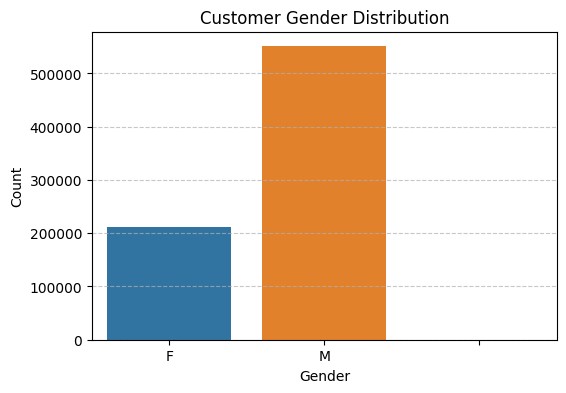

In [62]:
# Plot Gender Count
plt.figure(figsize=(6, 4))
sns.countplot(data=customers_df, x='CustGender', palette='tab10')

plt.title('Customer Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

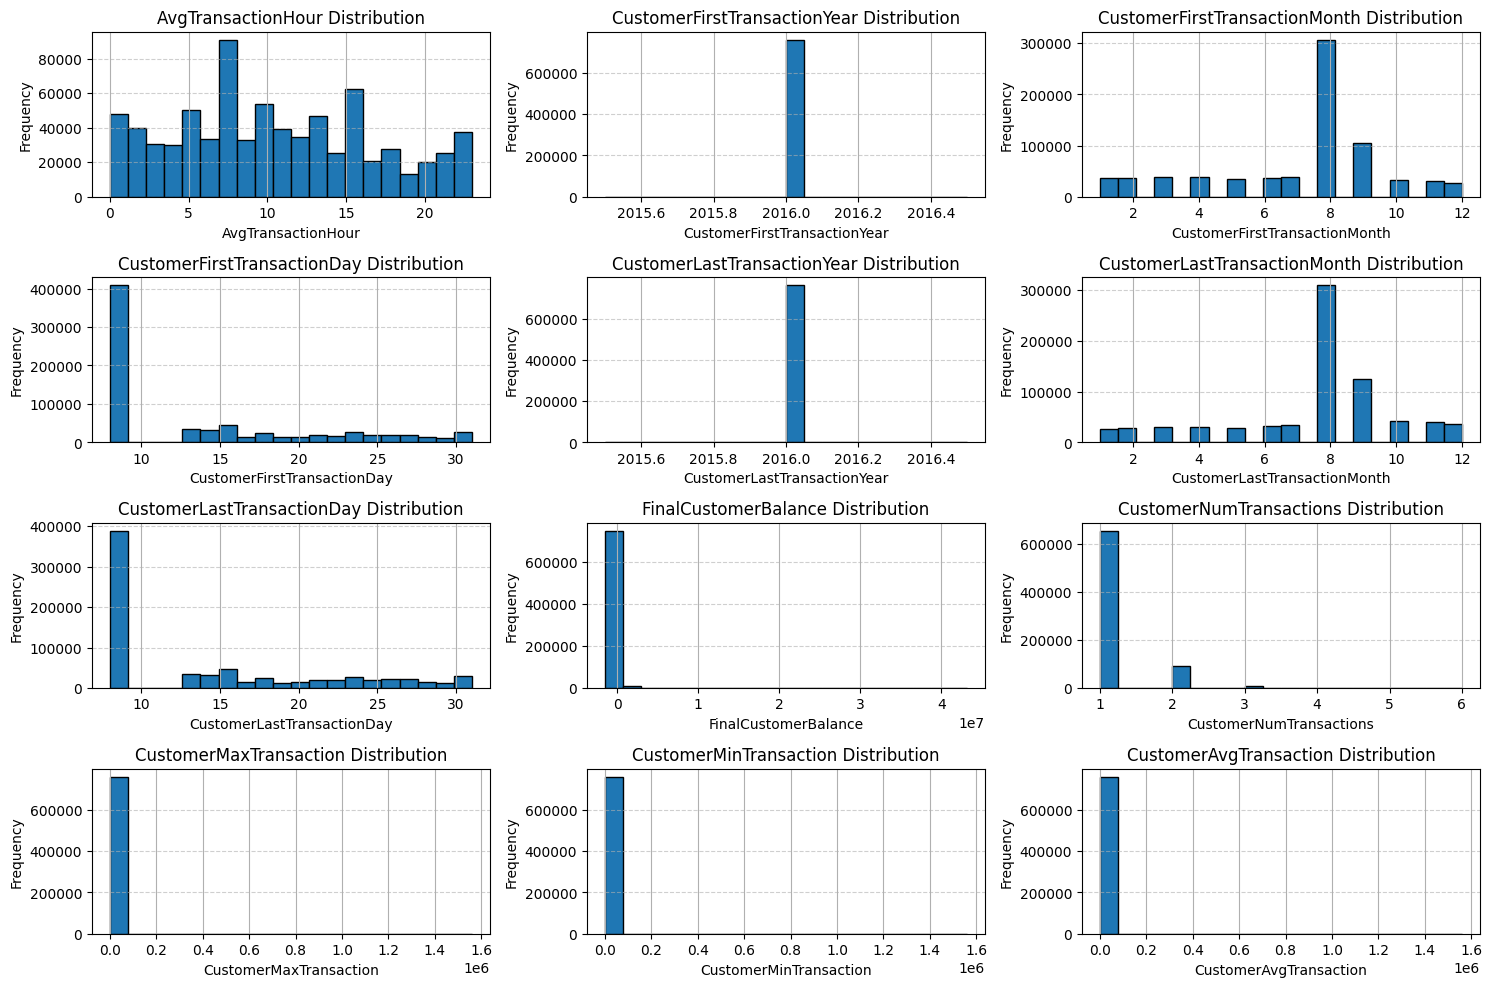

In [63]:
# List of columns to plot
hist_columns = [
                  'AvgTransactionHour',
                  'CustomerFirstTransactionYear', 'CustomerFirstTransactionMonth', 'CustomerFirstTransactionDay',
                  'CustomerLastTransactionYear', 'CustomerLastTransactionMonth', 'CustomerLastTransactionDay', 'FinalCustomerBalance',
                  'CustomerNumTransactions',	'CustomerMaxTransaction',	'CustomerMinTransaction',	'CustomerAvgTransaction'
              ]


# Plot histograms
plt.figure(figsize=(15, 12))

for i, col in enumerate(hist_columns, 1):

    plt.subplot(5, 3, i)
    customers_df[col].hist(bins=20, edgecolor='black')

    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [64]:
# We Can Observe that no variance exist in these columns ['CustomerFirstTransactionYear', 'CustomerLastTransactionYear'], thus we can drop these columns
customers_df.drop(columns=['CustomerFirstTransactionYear', 'CustomerLastTransactionYear'], inplace=True)

<ipython-input-64-66fbc660504d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_df.drop(columns=['CustomerFirstTransactionYear', 'CustomerLastTransactionYear'], inplace=True)


## **Encode the Data For Preparation to the clustering algorithm**

- In this section, Feature encoding was done on the Gender & Location Columns.

- These Columns had to be encoded in order to be able to use them in clustering algorithms.

- The categories of the gender were observed and some customers didn't have any gender associated to them thus they were assigned as Males.

- One Hot Encoding was done on the customer gender column.

- The Locations/Cities were observed and there were 7289 unique city.

- The cities contained ones that were misswritten, thus these cities were assigned to the correct city name.

- Only the most important cities in India were kept, while the other cities were assigned the "OTHER" label.

- One Hot Encoding was done on the modified locations column.

In [65]:
# Observe values of gender
customers_df['CustGender'].unique().tolist()

['F', 'M', '']

In [66]:
# Replace unknown gender with Male = 'M'
customers_df['CustGender'] = customers_df['CustGender'].replace('', 'M')

<ipython-input-66-5ca97d291549>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_df['CustGender'] = customers_df['CustGender'].replace('', 'M')


In [67]:
# One-hot encode CustGender
gender_ohe = pd.get_dummies(customers_df['CustGender'], prefix='Gender')

# Drop the original column
customers_df.drop(['CustGender'], axis=1, inplace=True)

# Concatenate the one-hot encoded columns
customers_df = pd.concat([customers_df, gender_ohe], axis=1)

<ipython-input-67-391e12b99969>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_df.drop(['CustGender'], axis=1, inplace=True)


In [68]:
# Observe the dataframe
customers_df

CustomerID CustLocation  cds  credit card  loans  long term investment  \
27922    C1010011        NOIDA    0            1      0                     0   
305895   C1010012       MUMBAI    0            1      1                     0   
212229   C1010014       MUMBAI    1            1      0                     1   
816156   C1010018    CHAMPARAN    0            0      1                     0   
537536   C1010028        DELHI    1            1      0                     1   
...           ...          ...  ...          ...    ...                   ...   
190568   C9099836     BHIWANDI    1            1      0                     0   
823199   C9099877    BANGALORE    0            0      0                     0   
337983   C9099919       GUNTUR    0            0      1                     0   
551433   C9099941      CHENNAI    0            1      0                     0   
24166    C9099956    MUSSOORIE    0            0      1                     0   

        retirement plan  savings  tds  CustomerAge  ...  \
27922                 0        1    0           24  ...   
305895                0        1    0           22  ...   
212229                1        1    1           31  ...   
816156                0        0    0           26  ...   
537536                1        1    1           28  ...   
...                 ...      ...  ...          ...  ...   
190568                1        1    1           25  ...   
823199                0        1    0           20  ...   
337983                0        1    0           22  ...   
551433                0        1    0           21  ...   
24166                 0        1    0           34  ...   

        TransactionPeriodDays  TransactionFrequencyPerDay  AvgTransactionHour  \
27922                      18                    0.111111                 6.5   
305895                      1                    1.000000                 8.0   
212229                    182                    0.010989                15.5   
816156                      1                    1.000000                23.0   
537536                      1                    1.000000                 2.0   
...                       ...                         ...                 ...   
190568                      1                    1.000000                 1.0   
823199                      1                    1.000000                 9.0   
337983                      1                    1.000000                10.0   
551433                      1                    1.000000                11.0   
24166                       1                    1.000000                14.0   

        FinalCustomerBalance  CustomerFirstTransactionMonth  \
27922               27750.73                              9   
305895              22705.49                              8   
212229             161598.76                              1   
816156                466.18                              9   
537536             296271.37                              8   
...                      ...                            ...   
190568             132376.23                              7   
823199              95841.46                              9   
337983               5433.75                              8   
551433              35245.92                              8   
24166                6113.93                              9   

        CustomerFirstTransactionDay  CustomerLastTransactionMonth  \
27922                             8                             9   
305895                           14                             8   
212229                            8                             7   
816156                           15                             9   
537536                           29                             8   
...                             ...                           ...   
190568                            8                             7   
823199                           15        

In [69]:
# Get the number of unique city names
len(customers_df['CustLocation'].unique().tolist())

7289

In [70]:
# Observe values of Location
locations = customers_df['CustLocation'].unique().tolist()
locations.sort()

locations

['',
 '(154) BHASKOLA FARIDABAD',
 '(BENAKA MDTS) BANGALORE',
 '(DT) HOSUR',
 '(E) MUMBAI',
 '(E) THANE SECTOR 3',
 '(EAST) MUMBAI',
 '(EAST) THANE',
 '(INDIA ) NAGPUR',
 '(KH) TAL MULSHI PUNE',
 '(METRO) NR RAM MANDIR KAMRUP(METRO)',
 '(N) 24 PGS',
 '(PIGEN) BANGALORE',
 '(PITAMPURA) NEW DELHI',
 '(RLY) NAGPUR',
 '(SAHIBABAD) GHAZIABAD',
 '(SOMWARPET KODAGU)',
 '(SUB URBAN) MUMBAI',
 '(SUBURBAN) MUMBAI',
 '(THANE)',
 '(URBAN) KRISHNA',
 '(VIA) SALEM',
 '(W)  MUMBAI',
 '(W) MUMBAI',
 '(W) S V RD MUMBAI',
 '(W) THANE',
 '(WEST) DELHI',
 '(WEST) DIST PALGHAR PALGHAR',
 '(WEST) MUMBAI',
 '.',
 '1 GURGAON',
 '10TH TO 11TH CROSS BANGALORE',
 '111 BLOCK BANGALORE BANGALORE',
 '12 DWARKA NEW DELHI',
 '127 ANDHERI KURLA RD ANDHERI MUMBAI',
 '13 GORAKHPUR',
 '13+AC0-5+AC0-431/A/1 HYDERABAD',
 '1600806 BANGALORE',
 '1601203 BANGALORE',
 '1601259 BANGALORE',
 '1601360 BANGALORE',
 '1601530 BANGALORE',
 '1601672 BANGALOE',
 '1601944 BANGALORE',
 '1601967 BANGALORE',
 '19D VASHI NAVI MUMBAI',
 '1ST

In [71]:
# Build a dictionary of similar names
similar_locations = {}
threshold = 60                # similarity percentage



# Get the similar locations for each location
for loc in locations:

    # Get the most similar cities to the current city (location) we have
    matches = process.extract(loc, locations, scorer=fuzz.ratio, limit=None)
    similar = [match for match, score, _ in matches if score >= threshold and match != loc]

    # Add the cities to our map
    if similar:
        similar_locations[loc] = similar

# Display misformatted groups
for base, group in similar_locations.items():
    print(f"{base} --> {group}")

(154) BHASKOLA FARIDABAD --> ['21 A FARIDABAD', '21A FARIDABAD', 'OLD FARIDABAD', 'BALLABGARH FARIDABAD', 'ROAD FARIDABAD', '21A FARIDBAD', 'MATHURA ROAD FARIDABAD', 'ESTATE FARIDABAD']
(BENAKA MDTS) BANGALORE --> ['PRATHIBHA MDTS) BANGALORE', 'BANK ATM BANGALORE', 'BANASWADI BANGALORE', 'BANK BANGALORE', '(PIGEN) BANGALORE', 'NAGAR POST BANGALORE', 'NAGAR BANGALORE', 'APARTMENT BANGALORE', 'APT BANGALORE', 'ATM BANGALORE', 'BAKERY BANGALORE', 'BANASHANKARI BANGALORE', 'BAZAAR BANGALORE', 'BELLANDUR BANGALORE', 'BILEKHALE BANGALORE', 'CENTER BANGALORE', 'CENTRE BANGALORE', 'D MART BANGALORE', 'DOUBLE RD BANGALORE', 'MARKET BANGALORE', 'SWEETS BANGALORE', 'VELAHANKA BANGALORE', 'YEHAKANKA BANGALORE', 'BANERGHATTA ROAD BANGALORE', 'BANNERGATTA ROAD BANGALORE', 'NEAR ARKERA GATE BANGALORE', 'KALIKA TEMPLE BANGALORE', 'NAGAR BUSSTOP BANGALORE', 'JAKASANDRA BANGALORE', 'NAGASANDRA BANGALORE', 'BG ROAD BANGALORE', 'BLOCK 3 BANGALORE', 'EMBASSY BANGALORE', 'KANNADA MANGALORE', 'MANTAPA BANGAL

In [72]:
# Only mark the most important cities to keep as they are in our data, while the rest will be Others
important_cities = ['MUMBAI', 'DELHI', 'BENGALURU', 'HYDERABAD', 'CHENNAI',
                    'KOLKATA', 'PUNE', 'AHMEDABAD', 'JAIPUR', 'LUCKNOW',
                    'CHANDIGARH', 'GURGAON']

In [73]:
corrections = {}      # Initialize the correction mapping

# Get all similar cities to the most important cities
for key in important_cities:

    similar_cities = similar_locations[key]

    for city in similar_cities:
        corrections[city] = key           # Map the wrong/misspelled city name to the correct name

customers_df['CustLocation'] = customers_df['CustLocation'].replace(corrections)            # replace wrong / misspelled cities

In [74]:
# Observe the dataframe
customers_df

CustomerID CustLocation  cds  credit card  loans  long term investment  \
27922    C1010011        NOIDA    0            1      0                     0   
305895   C1010012       MUMBAI    0            1      1                     0   
212229   C1010014       MUMBAI    1            1      0                     1   
816156   C1010018    CHAMPARAN    0            0      1                     0   
537536   C1010028        DELHI    1            1      0                     1   
...           ...          ...  ...          ...    ...                   ...   
190568   C9099836     BHIWANDI    1            1      0                     0   
823199   C9099877    BENGALURU    0            0      0                     0   
337983   C9099919       GUNTUR    0            0      1                     0   
551433   C9099941      CHENNAI    0            1      0                     0   
24166    C9099956    MUSSOORIE    0            0      1                     0   

        retirement plan  savings  tds  CustomerAge  ...  \
27922                 0        1    0           24  ...   
305895                0        1    0           22  ...   
212229                1        1    1           31  ...   
816156                0        0    0           26  ...   
537536                1        1    1           28  ...   
...                 ...      ...  ...          ...  ...   
190568                1        1    1           25  ...   
823199                0        1    0           20  ...   
337983                0        1    0           22  ...   
551433                0        1    0           21  ...   
24166                 0        1    0           34  ...   

        TransactionPeriodDays  TransactionFrequencyPerDay  AvgTransactionHour  \
27922                      18                    0.111111                 6.5   
305895                      1                    1.000000                 8.0   
212229                    182                    0.010989                15.5   
816156                      1                    1.000000                23.0   
537536                      1                    1.000000                 2.0   
...                       ...                         ...                 ...   
190568                      1                    1.000000                 1.0   
823199                      1                    1.000000                 9.0   
337983                      1                    1.000000                10.0   
551433                      1                    1.000000                11.0   
24166                       1                    1.000000                14.0   

        FinalCustomerBalance  CustomerFirstTransactionMonth  \
27922               27750.73                              9   
305895              22705.49                              8   
212229             161598.76                              1   
816156                466.18                              9   
537536             296271.37                              8   
...                      ...                            ...   
190568             132376.23                              7   
823199              95841.46                              9   
337983               5433.75                              8   
551433              35245.92                              8   
24166                6113.93                              9   

        CustomerFirstTransactionDay  CustomerLastTransactionMonth  \
27922                             8                             9   
305895                           14                             8   
212229                            8                             7   
816156                           15                             9   
537536                           29                             8   
...                             ...                           ...   
190568                            8                             7   
823199                           15        

In [75]:
# Only keep most the important cities, while the rest will be Others
customers_df['CustLocation'] = customers_df['CustLocation'].apply(lambda x: x if x in important_cities else 'OTHER')

In [76]:
# Observe the dataframe
customers_df

CustomerID CustLocation  cds  credit card  loans  long term investment  \
27922    C1010011        OTHER    0            1      0                     0   
305895   C1010012       MUMBAI    0            1      1                     0   
212229   C1010014       MUMBAI    1            1      0                     1   
816156   C1010018        OTHER    0            0      1                     0   
537536   C1010028        DELHI    1            1      0                     1   
...           ...          ...  ...          ...    ...                   ...   
190568   C9099836        OTHER    1            1      0                     0   
823199   C9099877    BENGALURU    0            0      0                     0   
337983   C9099919        OTHER    0            0      1                     0   
551433   C9099941      CHENNAI    0            1      0                     0   
24166    C9099956        OTHER    0            0      1                     0   

        retirement plan  savings  tds  CustomerAge  ...  \
27922                 0        1    0           24  ...   
305895                0        1    0           22  ...   
212229                1        1    1           31  ...   
816156                0        0    0           26  ...   
537536                1        1    1           28  ...   
...                 ...      ...  ...          ...  ...   
190568                1        1    1           25  ...   
823199                0        1    0           20  ...   
337983                0        1    0           22  ...   
551433                0        1    0           21  ...   
24166                 0        1    0           34  ...   

        TransactionPeriodDays  TransactionFrequencyPerDay  AvgTransactionHour  \
27922                      18                    0.111111                 6.5   
305895                      1                    1.000000                 8.0   
212229                    182                    0.010989                15.5   
816156                      1                    1.000000                23.0   
537536                      1                    1.000000                 2.0   
...                       ...                         ...                 ...   
190568                      1                    1.000000                 1.0   
823199                      1                    1.000000                 9.0   
337983                      1                    1.000000                10.0   
551433                      1                    1.000000                11.0   
24166                       1                    1.000000                14.0   

        FinalCustomerBalance  CustomerFirstTransactionMonth  \
27922               27750.73                              9   
305895              22705.49                              8   
212229             161598.76                              1   
816156                466.18                              9   
537536             296271.37                              8   
...                      ...                            ...   
190568             132376.23                              7   
823199              95841.46                              9   
337983               5433.75                              8   
551433              35245.92                              8   
24166                6113.93                              9   

        CustomerFirstTransactionDay  CustomerLastTransactionMonth  \
27922                             8                             9   
305895                           14                             8   
212229                            8                             7   
816156                           15                             9   
537536                           29                             8   
...                             ...                           ...   
190568                            8                             7   
823199                           15        

In [77]:
# One-hot encode CustLocation
location_ohe = pd.get_dummies(customers_df['CustLocation'], prefix='Loc')

# Drop the original column
customers_df.drop(['CustLocation'], axis=1, inplace=True)

# Concatenate the one-hot encoded columns
customers_df = pd.concat([customers_df, location_ohe], axis=1)

In [78]:
customers_df

CustomerID  cds  credit card  loans  long term investment  \
27922    C1010011    0            1      0                     0   
305895   C1010012    0            1      1                     0   
212229   C1010014    1            1      0                     1   
816156   C1010018    0            0      1                     0   
537536   C1010028    1            1      0                     1   
...           ...  ...          ...    ...                   ...   
190568   C9099836    1            1      0                     0   
823199   C9099877    0            0      0                     0   
337983   C9099919    0            0      1                     0   
551433   C9099941    0            1      0                     0   
24166    C9099956    0            0      1                     0   

        retirement plan  savings  tds  CustomerAge  CustomerNumTransactions  \
27922                 0        1    0           24                        2   
305895                0        1    0           22                        1   
212229                1        1    1           31                        2   
816156                0        0    0           26                        1   
537536                1        1    1           28                        1   
...                 ...      ...  ...          ...                      ...   
190568                1        1    1           25                        1   
823199                0        1    0           20                        1   
337983                0        1    0           22                        1   
551433                0        1    0           21                        1   
24166                 0        1    0           34                        1   

        ...  Loc_CHENNAI  Loc_DELHI  Loc_GURGAON  Loc_HYDERABAD  Loc_JAIPUR  \
27922   ...        False      False        False          False       False   
305895  ...        False      False        False          False       False   
212229  ...        False      False        False          False       False   
816156  ...        False      False        False          False       False   
537536  ...        False       True        False          False       False   
...     ...          ...        ...          ...            ...         ...   
190568  ...        False      False        False          False       False   
823199  ...        False      False        False          False       False   
337983  ...        False      False        False          False       False   
551433  ...         True      False        False          False       False   
24166   ...        False      False        False          False       False   

        Loc_KOLKATA  Loc_LUCKNOW  Loc_MUMBAI  Loc_OTHER  Loc_PUNE  
27922         False        False       False       True     False  
305895        False        False        True      False     False  
212229        False        False        True      False     False  
816156        False        False       False       True     False  
537536        False        False       False      False     False  
...             ...          ...         ...        ...       ...  
190568        False        False       False       True     False  
823199        False        False       False      False     False  
337983        False        False       False       True     False  
551433        False        False       False      False     False  
24166         False        False       False       True     False  

[761733 rows x 36 columns]

## **PCA**

- In this section Principal Component Analysis was performed on our data after scaling it using Standard Scaler.

- The goal was to Plot the Cumulative Variance Plot to get a clue of what is the best number of principal components to choose to reduce the dimensionality of our data.

- The top 14 PCAs were chosen to represent our data.

In [79]:
# Select numeric features only
numeric_cols = customers_df.select_dtypes(include=np.number)

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_cols)

# Fit PCA
pca = PCA()
pca = pca.fit(scaled_data)

# Calculate explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

In [80]:
print('Size of the transformed features:', pca.components_.shape)

Size of the transformed features: (20, 20)


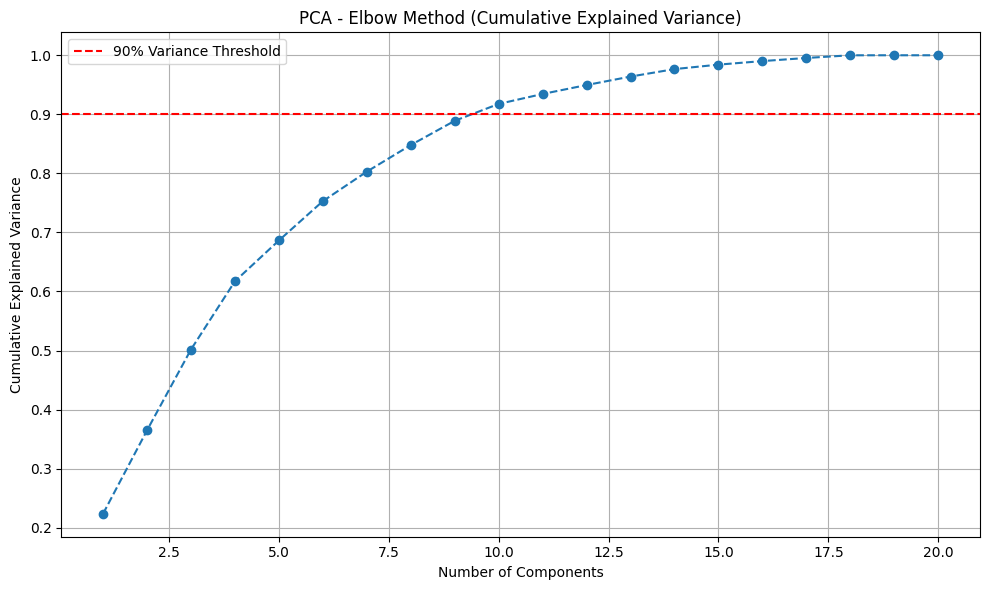

In [81]:
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')

plt.title('PCA - Elbow Method (Cumulative Explained Variance)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance Threshold')

plt.legend()
plt.tight_layout()
plt.show()

In [82]:
# Project the data on the top 14 principal components to reduce dimensionality
pca = PCA(n_components=14)
new_df = pca.fit_transform(scaled_data)

print('Shape of the newly transformed data:', new_df.shape)

Shape of the newly transformed data: (761733, 14)


## **Clustering**

- In this section, K-Means clustering was applied to the dimensionaly-reduced data obtained from PCA.

- Similar to the PCA procedure, multiple values of K (number of clusters) were tested, and an elbow curve was plotted to evaluate the effect of different K values on model inertia (within-cluster sum of squares).

- Based on the elbow curve, a few K values were selected for deeper analysis. For each chosen K, the following were performed:

    - Cluster statistics were extracted for key customer metrics such as: FinalCustomerBalance, CustomerNumTransactions, CustomerMaxTransaction, CustomerMinTransaction, and CustomerAvgTransaction.

    - Clusters were visualized in 2D using PCA projections to assess their spatial distribution and separability.

- After careful evaluation, K = 5 was selected as the optimal number of clusters. While K = 7 provides more granularity, K = 5 strikes a balance between capturing variability and maintaining computational efficiency.

- Insights were performed at the end of the section on 5 clusters to get an idea of how they are distributed, and what does each cluster prefer.

In [83]:
def pca_clusters(scaled_data, kmeans):

    '''
    Function that visualizes the customer clusters in 2D space using PCA (Principal Component Analysis).

    The function reduces the dimensionality of the input data to 2 components and plots the data points
    with the color-coded clusters from the KMeans algorithm.

    Args:
        scaled_data (DataFrame): The data to be reduced to 2D. It should be preprocessed and scaled.
        kmeans (KMeans object): The fitted KMeans model used to assign labels (clusters) to the data points.

    Returns:
        None
    '''

    # Reduce dimensions to 2D using PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(scaled_data)

    # Plot clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(components[:, 0], components[:, 1], c=kmeans.labels_, cmap='tab10', s=10, alpha=0.6)

    plt.title('Customer Clusters Visualized with PCA')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')

    plt.grid(True)
    plt.colorbar(label='Cluster')
    plt.show()

In [84]:
# Intialize the k-range (clusters) & an empty list to store the inertia corresponding to each k in the range
inertia = []
K_range = range(1, 11)

# Fit various Kmeans models with different clusters to plot the elbow curve
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(new_df)
    inertia.append(kmeans.inertia_)

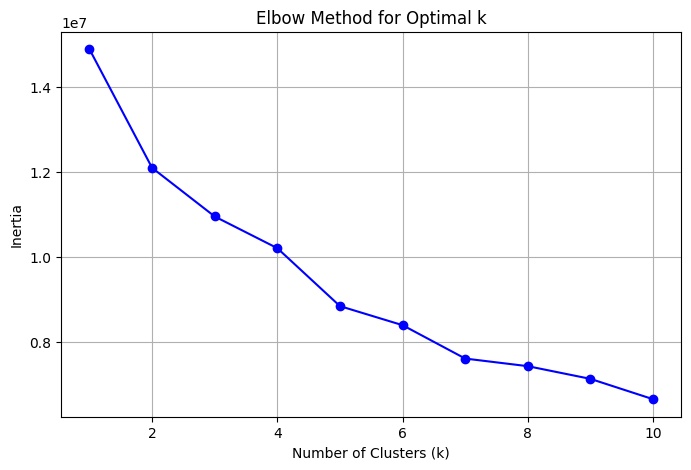

In [85]:
# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-')

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

plt.grid(True)
plt.show()

          FinalCustomerBalance                                         \
                          mean      median            std         min   
Cluster_3                                                               
0                 16685.401279    8875.770   40258.210965  -540542.00   
1                301576.010700  125775.110  722391.334611 -1517547.10   
2                 15872.954545    8574.565   36476.950482   -96375.69   

                       CustomerNumTransactions                           ...  \
                   max                    mean median       std min max  ...   
Cluster_3                                                                ...   
0           2212371.54                1.399932    1.0  0.591080   1   6  ...   
1          43165325.53                1.140937    1.0  0.386699   1   6  ...   
2           2274341.02                1.030429    1.0  0.172520   1   4  ...   

          CustomerMinTransaction                                        \
      

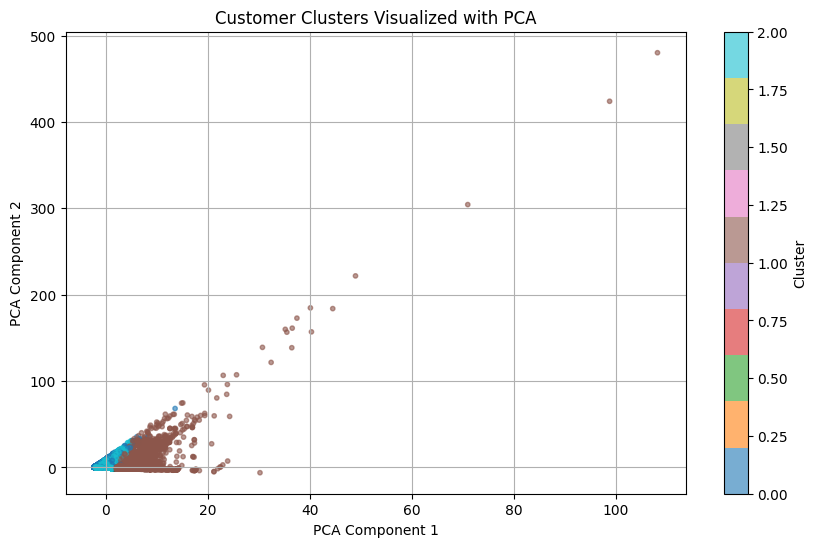

In [86]:
# Initialize K
k = 3

# Fit KMeans Model on our scaled data
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans.fit(new_df)

# Assign each customer in our data to a cluster
customers_df[f'Cluster_{k}'] = kmeans.labels_


# Observe statistics for each cluster: 'FinalCustomerBalance', 'CustomerNumTransactions',	'CustomerMaxTransaction',	'CustomerMinTransaction',	'CustomerAvgTransaction'
cluster_stats = customers_df.groupby(f'Cluster_{k}')[[
                                                      'FinalCustomerBalance',
                                                      'CustomerNumTransactions',
                                                      'CustomerMaxTransaction',
                                                      'CustomerMinTransaction',
                                                      'CustomerAvgTransaction'
                                                    ]].agg(['mean', 'median', 'std', 'min', 'max'])

# Get the clusters statistics
print(cluster_stats)

# Visualize PCA Clusters
pca_clusters(scaled_data, kmeans)

          FinalCustomerBalance                                         \
                          mean      median            std         min   
Cluster_4                                                               
0                 16481.478656    8752.070   38484.675314  -114236.97   
1                307910.529452  129387.205  732346.630688 -1517547.10   
2                 17882.434041    8843.265   45493.100821  -540542.00   
3                 16366.303016    8856.750   38364.351366  -118756.25   

                       CustomerNumTransactions                           ...  \
                   max                    mean median       std min max  ...   
Cluster_4                                                                ...   
0           2248820.54                1.009565    1.0  0.097715   1   3  ...   
1          43165325.53                1.124373    1.0  0.360714   1   5  ...   
2           2281289.02                1.540067    1.0  0.623475   1   6  ...   
3       

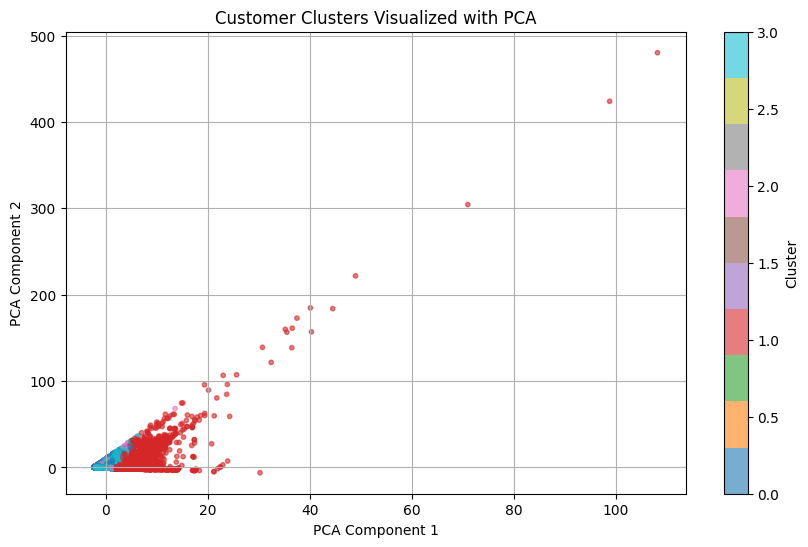

In [87]:
# Initialize K
k = 4

# Fit KMeans Model on our scaled data
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans.fit(new_df)

# Assign each customer in our data to a cluster
customers_df[f'Cluster_{k}'] = kmeans.labels_


# Observe statistics for each cluster: 'FinalCustomerBalance', 'CustomerNumTransactions',	'CustomerMaxTransaction',	'CustomerMinTransaction',	'CustomerAvgTransaction'
cluster_stats = customers_df.groupby(f'Cluster_{k}')[[
                                                      'FinalCustomerBalance',
                                                      'CustomerNumTransactions',
                                                      'CustomerMaxTransaction',
                                                      'CustomerMinTransaction',
                                                      'CustomerAvgTransaction'
                                                    ]].agg(['mean', 'median', 'std', 'min', 'max'])

# Get the clusters statistics
print(cluster_stats)

# Visualize PCA Clusters
pca_clusters(scaled_data, kmeans)

          FinalCustomerBalance                                         \
                          mean      median            std         min   
Cluster_5                                                               
0                 19343.561572   10209.015   44758.700848  -114236.97   
1                316131.233700  133105.210  752876.874863 -1517547.10   
2                 14375.091499    7005.210   35498.136858   -96375.69   
3                 18170.418183   10063.630   43326.958312  -118756.25   
4                 38346.006184   11323.920  130124.435493  -540542.00   

                       CustomerNumTransactions                           ...  \
                   max                    mean median       std min max  ...   
Cluster_5                                                                ...   
0           3007272.43                1.005921    1.0  0.077110   1   3  ...   
1          43165325.53                1.077438    1.0  0.274721   1   4  ...   
2           224

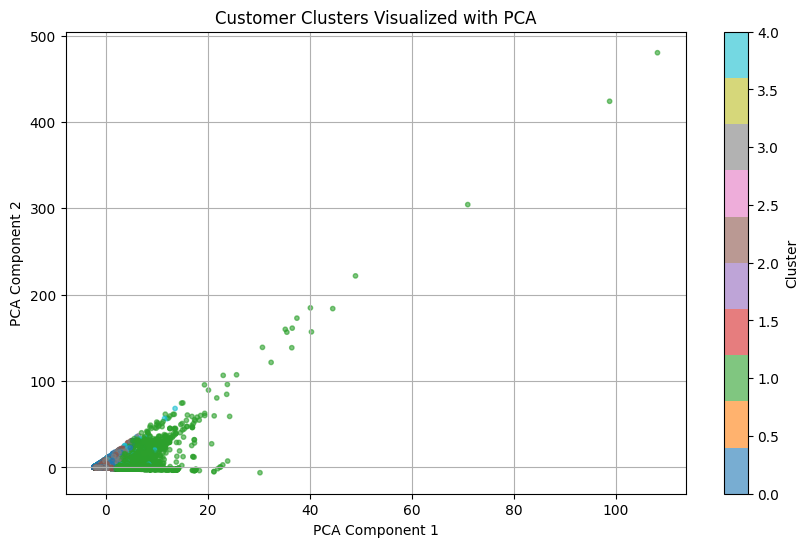

In [88]:
# Initialize K
k = 5

# Fit KMeans Model on our scaled data
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans.fit(new_df)

# Assign each customer in our data to a cluster
customers_df[f'Cluster_{k}'] = kmeans.labels_



# Observe statistics for each cluster: 'FinalCustomerBalance', 'CustomerNumTransactions',	'CustomerMaxTransaction',	'CustomerMinTransaction',	'CustomerAvgTransaction'
cluster_stats = customers_df.groupby(f'Cluster_{k}')[[
                                                      'FinalCustomerBalance',
                                                      'CustomerNumTransactions',
                                                      'CustomerMaxTransaction',
                                                      'CustomerMinTransaction',
                                                      'CustomerAvgTransaction'
                                                    ]].agg(['mean', 'median', 'std', 'min', 'max'])


# Get the clusters statistics
print(cluster_stats)

# Visualize PCA Clusters
pca_clusters(scaled_data, kmeans)

          FinalCustomerBalance                                        \
                          mean      median           std         min   
Cluster_7                                                              
0                 18586.344307    9032.505  4.520583e+04   -32985.31   
1                326891.530745  140922.950  7.588842e+05     2183.16   
2                 23609.068340   15586.170  4.540720e+04   -36372.69   
3                 31328.288234   18599.865  6.016653e+04   -30000.00   
4                 38328.988844   11519.940  1.286776e+05   -70422.73   
5                   971.350200     571.910  2.983227e+03   -55664.46   
6                294202.097106   18320.910  1.281191e+06 -1517547.10   

                       CustomerNumTransactions                           ...  \
                   max                    mean median       std min max  ...   
Cluster_7                                                                ...   
0           3007272.43                1

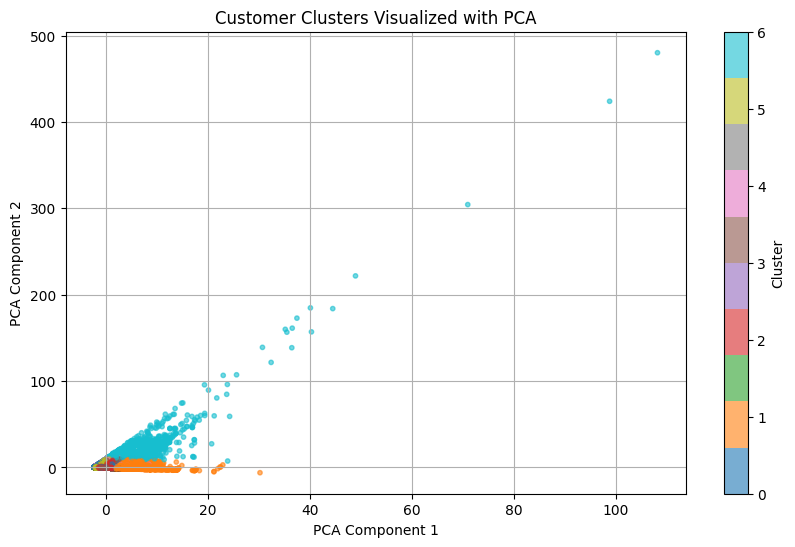

In [89]:
# Initialize K
k = 7

# Fit KMeans Model on our scaled data
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans.fit(new_df)

# Assign each customer in our data to a cluster
customers_df[f'Cluster_{k}'] = kmeans.labels_


# Observe statistics for each cluster: 'FinalCustomerBalance', 'CustomerNumTransactions',	'CustomerMaxTransaction',	'CustomerMinTransaction',	'CustomerAvgTransaction'
cluster_stats = customers_df.groupby(f'Cluster_{k}')[[
                                                      'FinalCustomerBalance',
                                                      'CustomerNumTransactions',
                                                      'CustomerMaxTransaction',
                                                      'CustomerMinTransaction',
                                                      'CustomerAvgTransaction'
                                                    ]].agg(['mean', 'median', 'std', 'min', 'max'])

# Get the clusters statistics
print(cluster_stats)

# Visualize PCA Clusters
pca_clusters(scaled_data, kmeans)

In [96]:
# Observe the dominant products in each cluster, to get an intuition of campaigns to run
cluster_stats = customers_df.groupby(f'Cluster_5')[['cds',
                                                    'credit card',
                                                    'loans',
                                                    'long term investment',
                                                    'retirement plan',
                                                    'savings',
                                                    'tds']].sum()

print('Owned Products in each cluster:\n\n\n', cluster_stats)

Owned Products in each cluster:


               cds  credit card   loans  long term investment  retirement plan  \
Cluster_5                                                                       
0            9464        69976  107964                  1651             5382   
1          142996       142965     864                 77847           138220   
2            7331        99895  201440                  1806             1765   
3            6897        82027  130382                  1506             1637   
4           14317        47314   63343                  4506            11524   

           savings    tds  
Cluster_5                  
0            95074    924  
1           142964  85495  
2           140565   1611  
3           109717   1066  
4            60642   4613  


#### **Cluster Insights Summary**

- **Cluster 0:**

    - Dominated by loans, suggesting customers may be younger or have lower budgets.

    - Also shows a preference for savings.


- **Cluster 1:**

    - Dominated by cds (Certificates of Deposit).

    - Dominated by retirement plans.

    - Dominated by credit cards — making it a prime target for campaigns suggesting credit card products to non-owners in this cluster. Most likely to prefer long-term investments and retirement plans.

    - Also shows strong preference for savings and TDS (Tax Deducted at Source), suggesting these customers are likely higher-budget or older.


- **Cluster 3:**

    - Strongly invested in loans and savings.

    - Similar behavior patterns to Cluster 4.


- **Cluster 4:**

    - Also leans toward loans and savings, possibly indicating similar demographics or financial needs as Cluster 3.

## **Bonus**

- In this section, a recommender system was built.

- The recommendation to each customer was done based on the products that customers within the same cluster already own, after filtering out products already owned by the customer.

- The output of the recommender system is sorted based on the popularity of that product in the cluster.

In [90]:
def recommender_system(customers_df, cust_id):

    '''
    Function that recommends products to a customer based on other customers in the same cluster.

    Args:
        customers_df (pd.DataFrame): The DataFrame with customer info and cluster labels.
        cust_id (str): The ID of the customer we want to recommend products to.

    Returns:
        list : Recommended products sorted by popularity in the cluster.
    '''

    # Get the cluster label as a scalar
    cust_cluster = customers_df[customers_df['CustomerID'] == cust_id]['Cluster_5'].iloc[0]

    # Filter customers in the same cluster
    customers_same_cluster = customers_df[customers_df['Cluster_5'] == cust_cluster]

    # Get customer owned
    cust_owned_products = customers_df[customers_df['CustomerID'] == cust_id][['cds',
                                                                               'credit card',
                                                                               'loans',
                                                                               'long term investment',
                                                                               'retirement plan',
                                                                               'savings',
                                                                               'tds']]

    owned_products = []
    for product, state in cust_owned_products.items():

        if state.iloc[0] == 1:
            owned_products.append(product)


    # Get the frequency of each product in that cluster, Get products not owned by user (sort by the most dominant product in that cluster)
    recommended_products = customers_same_cluster[['cds',
                                                   'credit card',
                                                   'loans',
                                                   'long term investment',
                                                   'retirement plan',
                                                   'savings',
                                                   'tds']].drop(columns=owned_products).sum().sort_values(ascending=False)


    return list(recommended_products.index)

In [91]:
customers_df

CustomerID  cds  credit card  loans  long term investment  \
27922    C1010011    0            1      0                     0   
305895   C1010012    0            1      1                     0   
212229   C1010014    1            1      0                     1   
816156   C1010018    0            0      1                     0   
537536   C1010028    1            1      0                     1   
...           ...  ...          ...    ...                   ...   
190568   C9099836    1            1      0                     0   
823199   C9099877    0            0      0                     0   
337983   C9099919    0            0      1                     0   
551433   C9099941    0            1      0                     0   
24166    C9099956    0            0      1                     0   

        retirement plan  savings  tds  CustomerAge  CustomerNumTransactions  \
27922                 0        1    0           24                        2   
305895                0        1    0           22                        1   
212229                1        1    1           31                        2   
816156                0        0    0           26                        1   
537536                1        1    1           28                        1   
...                 ...      ...  ...          ...                      ...   
190568                1        1    1           25                        1   
823199                0        1    0           20                        1   
337983                0        1    0           22                        1   
551433                0        1    0           21                        1   
24166                 0        1    0           34                        1   

        ...  Loc_JAIPUR  Loc_KOLKATA  Loc_LUCKNOW  Loc_MUMBAI  Loc_OTHER  \
27922   ...       False        False        False       False       True   
305895  ...       False        False        False        True      False   
212229  ...       False        False        False        True      False   
816156  ...       False        False        False       False       True   
537536  ...       False        False        False       False      False   
...     ...         ...          ...          ...         ...        ...   
190568  ...       False        False        False       False       True   
823199  ...       False        False        False       False      False   
337983  ...       False        False        False       False       True   
551433  ...       False        False        False       False      False   
24166   ...       False        False        False       False       True   

        Loc_PUNE  Cluster_3  Cluster_4  Cluster_5  Cluster_7  
27922      False          0          2          4          4  
305895     False          2          3          2          2  
212229     False          1          1          4          4  
816156     False          2          3          2          5  
537536     False          1          1          1          1  
...          ...        ...        ...        ...        ...  
190568     False          1          1          1          1  
823199     False          2          3          2          2  
337983     False          2          3          3          2  
551433     False          2          3          3          3  
24166      False          2          3          3          3  

[761733 rows x 40 columns]

In [ ]:
cust_id = 'C7521887'
print(f'Recommended Products for customer {cust_id}:', recommender_system(customers_df, cust_id=cust_id))

Recommended Products for customer C7521887: ['cds', 'long term investment', 'retirement plan', 'tds']
